In [1]:
# this just checks that i have the right kernel running
import sys
print(sys.executable)

import random
random.seed(0)

/Users/emmanechamkin/miniconda3/envs/advml/bin/python


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from config import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn import model_selection, linear_model, naive_bayes, metrics

## References 
- https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/
- https://stackoverflow.com/questions/14003291/n-grams-with-naive-bayes-classifier

## Read in the data

In [3]:
train_df = pd.read_csv(TRAIN)
train_df.shape

(768, 2)

In [4]:
validate_df = pd.read_csv(VALIDATE)
validate_df.shape

(768, 2)

In [5]:
test_df = pd.read_csv(TEST)
test_df.shape

(1, 2)

## Get to work!

In [6]:
## only training data now
tweet_corpus = train_df.iloc[:, 0]
tweet_sentiment = train_df.iloc[:, 1]

# note that I do this in both files. I wanted to keep 
# my categories flexible from file to file, and this is 
# the execution of a single switch. I didn't think I 
# absolutely needed to refactor here. 
tweet_sentiment_coded = pd.Series(np.where(
    tweet_sentiment == 'About the police - Positive', 1, 
        np.where(tweet_sentiment == 'About the police - Negative', 2, 
            np.where(tweet_sentiment == 'About the police - Neutral', 3, 
                np.where(tweet_sentiment == 'Not about the police', 0, "Error")))))

# Exploring features

I looked at bag of words, bigrams, tweet length, similarity matrices and clustering, tfidf for this analysis

In [42]:
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(tweet_corpus)
cv_matrix = cv_matrix.toarray()
vocab = cv.get_feature_names()

MINIMUM_CT = 20 #(appear in ~2% of tweets)

# show document feature vectors
cv_matrix = pd.DataFrame(cv_matrix, columns=vocab)
freq_cv_matrix = cv_matrix[cv_matrix.columns[cv_matrix.sum() > MINIMUM_CT]]

freq_cv_matrix.sum()

alert            23
amp              38
arrest           38
arson            29
attempt          29
babi             87
black            28
charg            32
chicago         417
chicagopolic    119
citi             23
cocktail         22
cut              48
cwbchicago       40
dead             40
depart           28
doc              22
facebook         21
found            65
home             35
illinoi          22
man              26
marlen           21
mayor            31
miss             69
molotov          22
murder           31
new              22
offic            27
peopl            35
polic           410
pregnant         96
report           37
say              69
strangl          31
synagogu         54
teen             27
three            25
train            21
via              24
woman            86
womb             58
dtype: int64

In [53]:
freq_cv_matrix.sum().sort_values(ascending=False).head(20)

chicago         417
polic           410
chicagopolic    119
pregnant         96
babi             87
woman            86
say              69
miss             69
found            65
womb             58
synagogu         54
cut              48
cwbchicago       40
dead             40
arrest           38
amp              38
report           37
peopl            35
home             35
charg            32
dtype: int64

In [8]:
# bigrams 
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(tweet_corpus).toarray()

MINIMUM_CT = 25

# show document feature vectors
vocab = bv.get_feature_names()
bv_matrix_df = pd.DataFrame(bv_matrix, columns=vocab)
freq_bv_matrix = bv_matrix_df[bv_matrix_df.columns[bv_matrix_df.sum() > MINIMUM_CT]]

print(freq_bv_matrix.columns)
print(freq_bv_matrix.sum())

Index(['babi cut', 'chicago polic', 'cut womb', 'cwbchicago chicagopolic',
       'found dead', 'miss pregnant', 'polic say', 'pregnant woman'],
      dtype='object')
babi cut                    41
chicago polic              166
cut womb                    39
cwbchicago chicagopolic     28
found dead                  34
miss pregnant               33
polic say                   40
pregnant woman              56
dtype: int64


In [9]:
# length of tweet in characters 
tweet_len = tweet_corpus.apply(lambda x: len(x))
print(tweet_len.sort_values().head(5))
print(tweet_len.sort_values().tail(5))

10      5
732     6
186    12
466    14
164    23
Name:  inputtext, dtype: int64
614    119
612    120
252    120
630    121
714    122
Name:  inputtext, dtype: int64


These very short tweets suggest errors -- stuff that is getting cleaned out of the tweets, like links, perhaps. However, if this is a useful tool, it's one that looks at all tweets. I didn't want to filter out all short tweets for that very reason. 

In [10]:
tv = TfidfVectorizer(use_idf=True)
tv_matrix = tv.fit_transform(tweet_corpus)
tv_matrix = tv_matrix.toarray()

# tweet similarity matrix 
similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)

similarity_df.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,1.000000,0.018211,0.0,0.012233,0.006816,0.005285,0.009136,0.014361,0.000000,0.012343,...,0.014808,0.014585,0.034544,0.017622,0.013431,0.005425,0.003838,0.000000,0.021978,0.007416
1,0.018211,1.000000,0.0,0.020322,0.015090,0.005851,0.010113,0.023856,0.000000,0.020504,...,0.027329,0.080953,0.063754,0.029274,0.022311,0.012011,0.008496,0.000000,0.036509,0.016418
2,0.000000,0.000000,1.0,0.000000,0.000000,0.052002,0.000000,0.000000,0.080692,0.000000,...,0.000000,0.073774,0.000000,0.000000,0.000000,0.000000,0.000000,0.027559,0.000000,0.000000
3,0.012233,0.020322,0.0,1.000000,0.007606,0.005898,0.010196,0.016026,0.000000,0.013774,...,0.016524,0.016276,0.038549,0.019666,0.014988,0.006054,0.004283,0.000000,0.024526,0.008276
4,0.006816,0.015090,0.0,0.007606,1.000000,0.000000,0.124784,0.008929,0.000000,0.007674,...,0.012270,0.009068,0.028624,0.010957,0.008351,0.006737,0.004765,0.000000,0.163520,0.009208


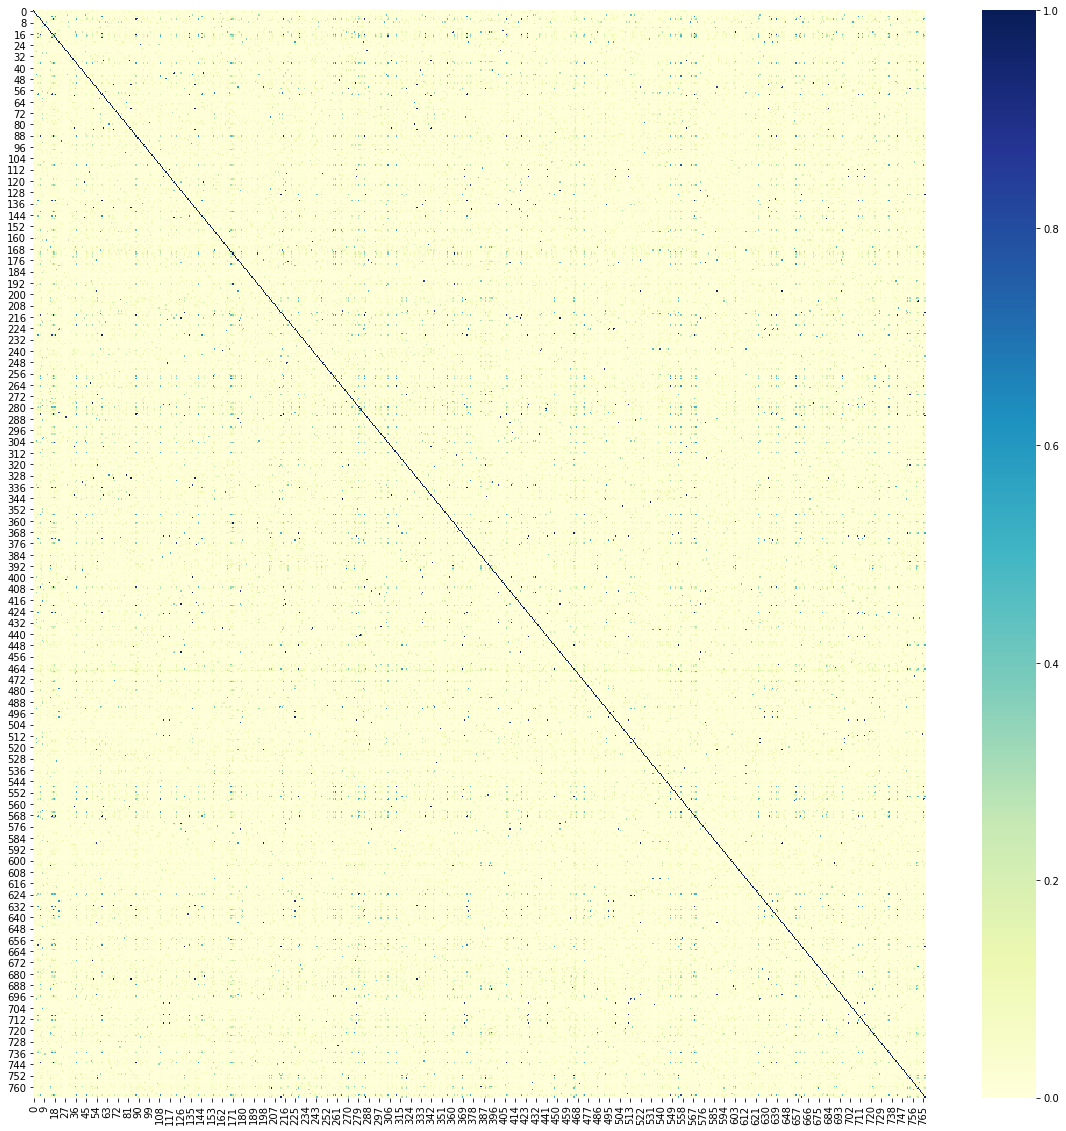

In [11]:
# heat map
plt.figure(figsize=(20, 20))
sns.heatmap(similarity_df, vmin=0, vmax=1, cmap="YlGnBu")

In [12]:
# clustering 
Z = linkage(similarity_matrix, 'ward')
max_dist = 3.0

cluster_labels = fcluster(Z, max_dist, criterion='distance')
cluster_labels = pd.DataFrame(cluster_labels, columns=['cluster'])
cluster_df = pd.concat([train_df, cluster_labels], axis=1)

cluster_by_type = (cluster_df
                   .groupby(['cluster', 'Answer.sentiment.label'])
                   .count()
                   .reset_index()
                   .rename(columns = {" inputtext": "count"}))

In [13]:
popular_clusters = (cluster_df
                    .groupby(['cluster'])[['cluster']]
                    .filter(lambda x: x.count() > 20.)['cluster']
                    .unique())

# not the most elegant, but it works!
graph_cluster_filter = cluster_by_type.cluster.isin(popular_clusters)
graph_cluster = cluster_by_type[graph_cluster_filter]

(768, 3)

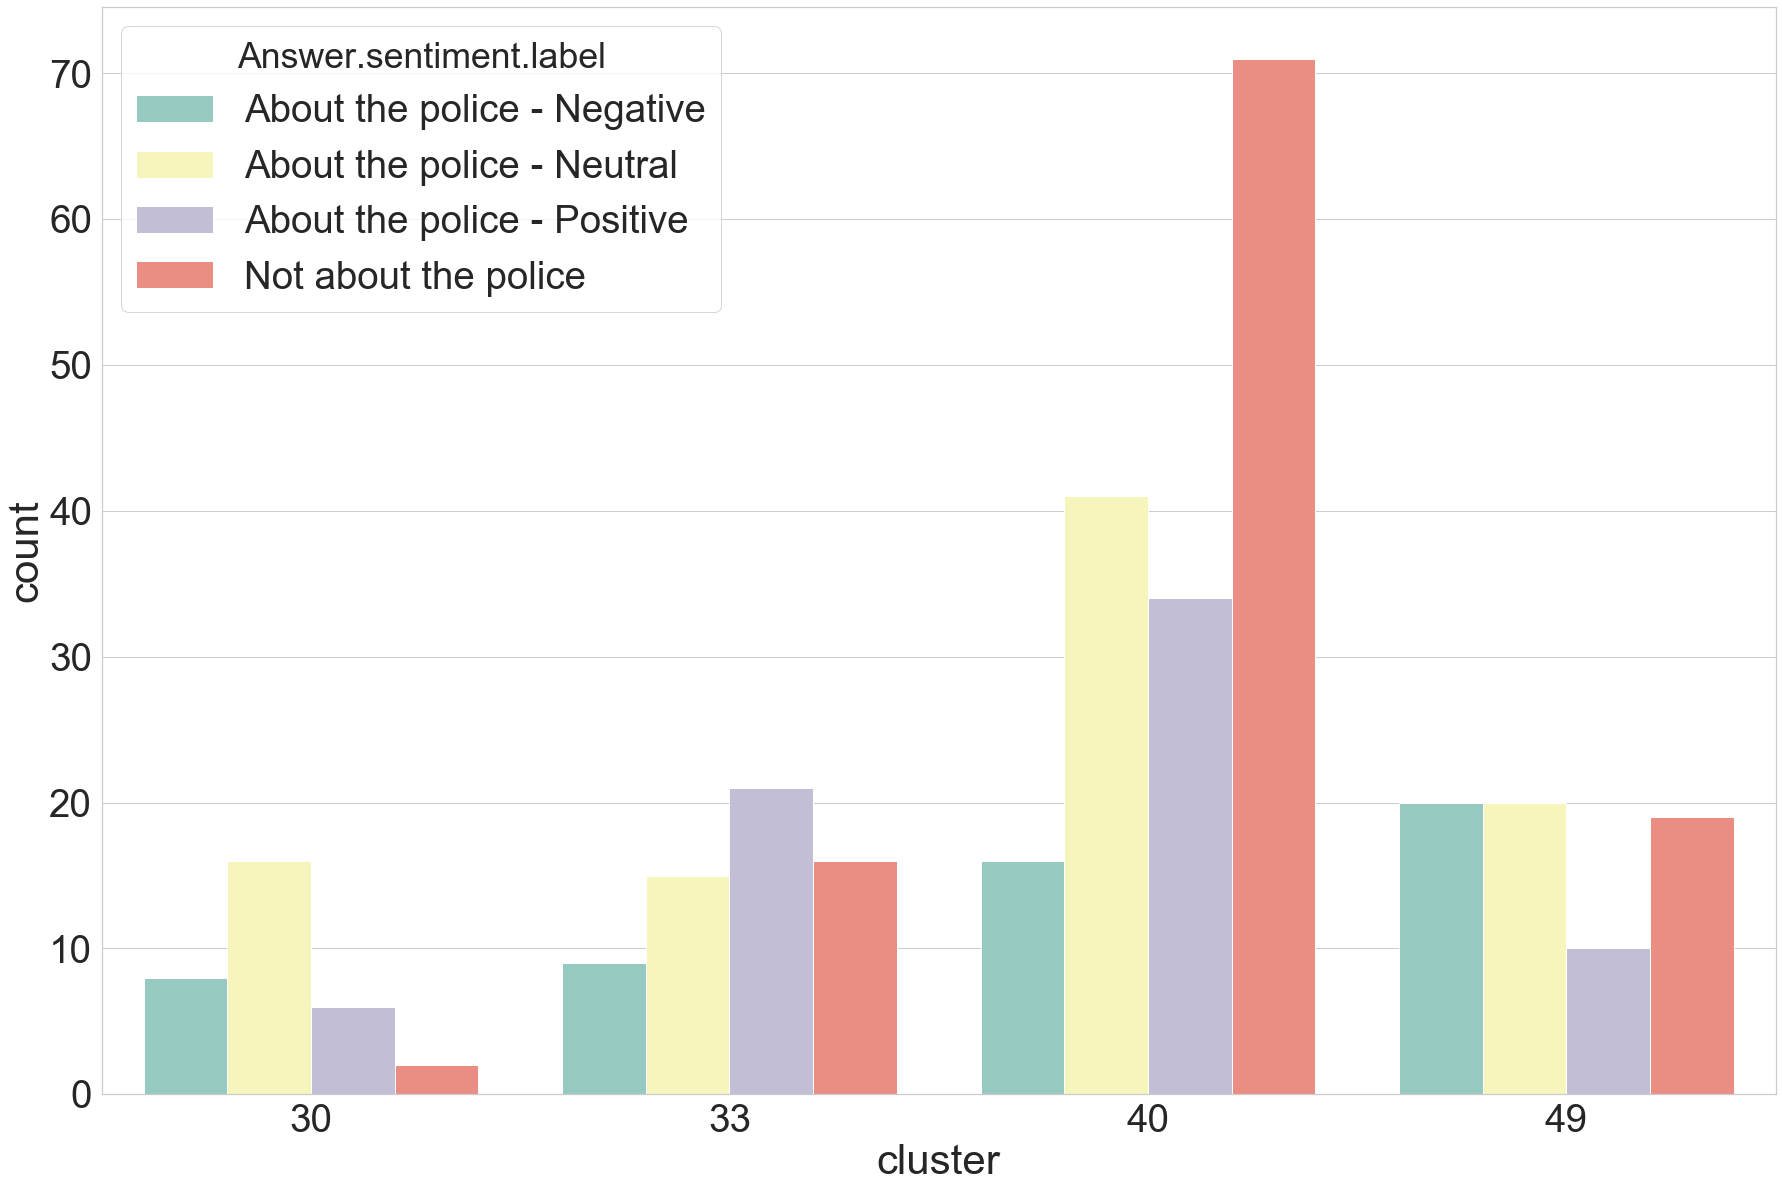

In [39]:
# find top clusters 
sns.set_style("whitegrid")
with sns.plotting_context("notebook", font_scale=3.5):
    plt.figure(figsize=(30, 20))
    sns.barplot(
        x="cluster", y="count", 
        hue="Answer.sentiment.label", data=graph_cluster, 
        palette="Set3")
    
cluster_df.shape

In [63]:
cluster_df[cluster_df["cluster"] == 40][' inputtext']

0       artsprison williamay convers wthe author tort...
10                                                  word
13      skarstw true yet karma polic live chicago wor...
38      sassadnew often chicago polic make arrest rap...
40      michelewood50 amaz time armygk coupl bravest ...
41      chuckcallesto jamesajames19 get polic report ...
43      chicagobienni report usatoday 100plu affili n...
53      lake counti sheriff sergeant graduat northwes...
56      got goosebump watch video holm want legaci li...
61      markriveraabc7 abc7chicago chicago polic dumb...
63      chicago despit increas tax revenu new mayor f...
71      serious stop hook peopl stick polic drama lea...
77      theft cold 9400 block n chicago ave portland ...
82      want thank bluebloodscb provid dad hour hour ...
91      trenoel polic reaction amp stadium gtlittl pr...
101     michaelgmast jewish commun officialscn apprec...
103     iotprivacyforum chicago detroit purchas softw...
104     aw horribl tragic news 

This suggests that this will be somewhat good at picking up police / not police text

To get a sense of how many have fewer than 10 members...

In [16]:
(cluster_df.groupby(['cluster'])[['cluster']]
           .filter(lambda x: x.count() < 10.)['cluster']
           .unique()).shape

(39,)

And how many clusters there are...

In [17]:
cluster_df.cluster.unique().shape

(62,)

## Building models

Can I predict *negative sentiment* to the police?? 

In [18]:
# this has become my label :)
train_negsentiment_coded = pd.Series(
    np.where(
        tweet_sentiment == 'About the police - Negative', 1, 0))
    

In [19]:
# for data hygeine
train_negsentiment_coded.value_counts()

0    634
1    134
dtype: int64

In [20]:
validate_corpus = validate_df.iloc[:, 0]
valid_negsentiment_coded = pd.Series(np.where(
        validate_df.iloc[:, 1] == 'About the police - Negative', 1, 0))

In [21]:
# for data hygeine
valid_negsentiment_coded.value_counts()

0    616
1    152
dtype: int64

In [22]:
valid_sentiment_coded = pd.Series(np.where(
    validate_df.iloc[:, 1] == 'About the police - Positive', 1, 
        np.where(validate_df.iloc[:, 1] == 'About the police - Negative', 2, 
            np.where(validate_df.iloc[:, 1] == 'About the police - Neutral', 3, 
                np.where(validate_df.iloc[:, 1] == 'Not about the police', 0, "Error")))))

In [23]:
# transform the training and validation data in unigrams
uni_xtrain_count =  cv.transform(tweet_corpus)
uni_xvalid_count =  cv.transform(validate_corpus)

# transform the training and validation data in bigrams
bi_xtrain_count =  bv.transform(tweet_corpus)
bi_xvalid_count =  bv.transform(validate_corpus)

In [24]:
# word tfidf
unigram_tfidf_xtrain =  tv.transform(tweet_corpus)
unigram_tfidf_xvalid =  tv.transform(validate_corpus)

# bigram tfidf
tv2 = TfidfVectorizer(ngram_range=(2,3))
tv2.fit(tweet_corpus)
bigram_tfidf_xtrain =  tv2.transform(tweet_corpus)
bigram_tfidf_xvalid =  tv2.transform(validate_corpus)

In [25]:
# word cv
unigram_xtrain = cv.transform(tweet_corpus)
unigram_xvalid = cv.transform(validate_corpus)

# bigram cv
bigram_xtrain = bv.transform(tweet_corpus)
bigram_xvalid = bv.transform(validate_corpus)

In [26]:
def train_classifier(classifier, xtrain, ytrain, xvalid, yvalid, avg="binary"):
    """
    General function to train classifier
    
    Inputs
    - classifier
    - xtrain and ytrain, two sets of data
    - xvalid and yvalid, ditto but for validation
    - avg is parameter for multiclass
    Returns
    - accuracy score
    - y pred for validation set
    - y pred for testing set
    """
    classifier.fit(xtrain, ytrain)
    xpred = classifier.predict(xtrain)
    pred = classifier.predict(xvalid)
    return metrics.accuracy_score(pred, yvalid), \
           metrics.precision_score(pred, yvalid, average=avg), \
           xpred, pred

# Baseline rate

In [27]:
valid_negsentiment_coded.value_counts().transform(lambda x: x/x.sum())

0    0.802083
1    0.197917
dtype: float64

## Naive Bayes

In [28]:
nb_uni_accuracy, nb_uni_precision, train_nb_uni_pred, nb_uni_pred = \
    train_classifier(classifier=naive_bayes.MultinomialNB(),
                 xtrain=uni_xtrain_count, 
                 ytrain=train_negsentiment_coded, 
                 xvalid=uni_xvalid_count,
                 yvalid=valid_negsentiment_coded)

print(f"Validation set: NB Unigram\n\tprecision {nb_uni_precision}\n\t accuracy {nb_uni_accuracy}")
      

Validation set: NB Unigram
	precision 0.2565789473684211
	 accuracy 0.8111979166666666


In [29]:
nb_bi_accuracy, nb_bi_precision, train_nb_bi_pred, nb_bi_pred = \
    train_classifier(classifier=naive_bayes.MultinomialNB(),
                 xtrain=bi_xtrain_count, 
                 ytrain=train_negsentiment_coded, 
                 xvalid=bi_xvalid_count,
                 yvalid=valid_negsentiment_coded)

print(f"Validation set: NB Bigram\n\tprecision {nb_bi_precision}\n\t accuracy {nb_bi_accuracy}")


Validation set: NB Bigram
	precision 0.20394736842105263
	 accuracy 0.80078125


In [30]:
nb_tfidf_uni_accuracy, nb_tfidf_uni_precision, train_tfidf_uni_pred, nb_tfidf_uni_pred = \
    train_classifier(classifier=naive_bayes.MultinomialNB(),
                 xtrain=unigram_tfidf_xtrain, 
                 ytrain=train_negsentiment_coded, 
                 xvalid=unigram_tfidf_xvalid,
                 yvalid=valid_negsentiment_coded)

print(f"Validation set: NB Bigram\n\tprecision {nb_tfidf_uni_precision}\n\t accuracy {nb_tfidf_uni_accuracy}")

Validation set: NB Bigram
	precision 0.09210526315789473
	 accuracy 0.8177083333333334


In [31]:
nb_tfidf_bi_accuracy, nb_tfidf_bi_precision, train_tfidf_bi_pred, nb_tfidf_bi_pred = \
    train_classifier(classifier=naive_bayes.MultinomialNB(),
                 xtrain=bigram_tfidf_xtrain, 
                 ytrain=train_negsentiment_coded, 
                 xvalid=bigram_tfidf_xvalid,
                 yvalid=valid_negsentiment_coded)

print(f"Validation set: NB Bigram\n\tprecision {nb_tfidf_bi_precision}\n\t accuracy {nb_tfidf_bi_accuracy}")

Validation set: NB Bigram
	precision 0.09210526315789473
	 accuracy 0.8072916666666666


## logistic regression

In [32]:
lr_uni_accuracy, lr_uni_precision, train_lr_uni_pred, lr_uni_pred = \
    train_classifier(classifier=linear_model.LogisticRegression(),
                 xtrain=uni_xtrain_count, 
                 ytrain=train_negsentiment_coded, 
                 xvalid=uni_xvalid_count,
                 yvalid=valid_negsentiment_coded)

print(f"Validation set: LR Unigram\n\tprecision {lr_uni_precision}\n\t accuracy {lr_uni_accuracy}")

Validation set: LR Unigram
	precision 0.17105263157894737
	 accuracy 0.8072916666666666


/Users/emmanechamkin/miniconda3/envs/advml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
lr_bi_accuracy, lr_bi_precision, train_lr_bi_pred, lr_bi_pred = \
    train_classifier(classifier=linear_model.LogisticRegression(),
                 xtrain=bi_xtrain_count, 
                 ytrain=train_negsentiment_coded, 
                 xvalid=bi_xvalid_count,
                 yvalid=valid_negsentiment_coded)

print(f"Validation set: NB Bigram\n\tprecision {lr_bi_precision}\n\t accuracy {lr_bi_accuracy}")

Validation set: NB Bigram
	precision 0.14473684210526316
	 accuracy 0.8033854166666666


In [34]:
lr_tfidf_uni_accuracy, lr_tfidf_uni_precision, lr_train_tfidf_uni_pred, lr_tfidf_uni_pred = \
    train_classifier(classifier=linear_model.LogisticRegression(),
                 xtrain=unigram_tfidf_xtrain, 
                 ytrain=train_negsentiment_coded, 
                 xvalid=unigram_tfidf_xvalid,
                 yvalid=valid_negsentiment_coded)

print(f"Validation set: LR Bigram\n\tprecision {lr_tfidf_uni_precision}\n\t accuracy {lr_tfidf_uni_accuracy}")

Validation set: LR Bigram
	precision 0.09210526315789473
	 accuracy 0.8177083333333334


In [35]:
lr_tfidf_bi_accuracy, lr_tfidf_bi_precision, lr_train_tfidf_bi_pred, lr_tfidf_bi_pred = \
    train_classifier(classifier=linear_model.LogisticRegression(),
                 xtrain=bigram_tfidf_xtrain, 
                 ytrain=train_negsentiment_coded, 
                 xvalid=bigram_tfidf_xvalid,
                 yvalid=valid_negsentiment_coded)

print(f"Validation set: LR Bigram\n\tprecision {lr_tfidf_bi_precision}\n\t accuracy {lr_tfidf_bi_accuracy}")


Validation set: LR Bigram
	precision 0.05921052631578947
	 accuracy 0.8125


# All four categories
All four categories were pretty bad. To show you, here is the "best" traditional model performing on all 4 categories. 

I set the metric equal to macro here, as per the sklearn docs:

""macro" simply calculates the mean of the binary metrics, giving equal weight to each class. In problems where infrequent classes are nonetheless important, macro-averaging may be a means of highlighting their performance. On the other hand, the assumption that all classes are equally important is often untrue, such that macro-averaging will over-emphasize the typically low performance on an infrequent class."

https://scikit-learn.org/stable/modules/model_evaluation.html#multiclass-and-multilabel-classification

In [36]:
all_nb_bi_accuracy, all_nb_bi_precision, all_train_nb_bi_pred, all_nb_bi_pred = \
    train_classifier(classifier=naive_bayes.MultinomialNB(),
                 xtrain=bi_xtrain_count, 
                 ytrain=tweet_sentiment_coded, 
                 xvalid=bi_xvalid_count,
                 yvalid=valid_sentiment_coded, 
                 avg="macro")

print(f"Validation set: NB Bigram\n\tprecision {all_nb_bi_precision}\n\t accuracy {all_nb_bi_accuracy}")

Validation set: NB Bigram
	precision 0.3626566382442845
	 accuracy 0.4192708333333333


## final thing -- detect opinion vs not

In [37]:
opinion_detector_train = pd.Series(
    np.where(tweet_sentiment == 'About the police - Negative', 1, 
            np.where(tweet_sentiment == 'About the police - Positive', 1, 0)))

opinion_detector_validate = pd.Series(
    np.where(validate_df.iloc[:, 1] == 'About the police - Negative', 1, 
            np.where(validate_df.iloc[:, 1] == 'About the police - Positive', 1, 0)))


In [38]:
op_nb_bi_accuracy, op_nb_bi_precision, op_train_nb_bi_pred, op_nb_bi_pred = \
    train_classifier(classifier=naive_bayes.MultinomialNB(),
                 xtrain=bi_xtrain_count, 
                 ytrain=opinion_detector_train, 
                 xvalid=bi_xvalid_count,
                 yvalid=opinion_detector_validate)

print(f"Validation set: NB Bigram\n\tprecision {op_nb_bi_precision}\n\t accuracy {op_nb_bi_accuracy}")


Validation set: NB Bigram
	precision 0.3519163763066202
	 accuracy 0.6666666666666666
